In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    
    # CMIP data       
    cmip_sst = torch.load("process_data/cmip_sst_data.pt")  ## 56156, 12, 24, 72
    cmip_t300 = torch.load("process_data/cmip_t300_data.pt")
    cmip_ua = torch.load("process_data/cmip_ua_data.pt")
    cmip_va = torch.load("process_data/cmip_va_data.pt")
    cmip_label = torch.load("process_data/cmip_label.pt")
    
    soda_sst = torch.load("process_data/soda_sst_data.pt")  # (1189, 12, 24, 72)
    soda_t300 = torch.load("process_data/soda_t300_data.pt")
    soda_ua = torch.load("process_data/soda_ua_data.pt")
    soda_va = torch.load("process_data/soda_va_data.pt")
    soda_label = torch.load("process_data/soda_label.pt")

    dict_cmip = {
        'sst':cmip_sst,
        't300':cmip_t300,
        'ua':cmip_ua,
        'va': cmip_va,
        'label': cmip_label}
    dict_soda = {
        'sst':soda_sst,
        't300':soda_t300,
        'ua':soda_ua,
        'va': soda_va,
        'label': soda_label}
    
    cmip_dataset = EarthDataSet(dict_cmip)
    soda_dataset = EarthDataSet(dict_soda)
    
    train_1, valid_1 = random_split(cmip_dataset, [50000, 5388])
    train_2, valid_2 = random_split(soda_dataset, [1000, 189])
    
    train_dataset = train_1 + train_2 + train_2 + train_2 + train_2
    valid_dataset = valid_1
    valid_dataset_2 = valid_2
    
    print('Train samples: {}, Valid1 samples: {}, Valid2 samples: {}'.format(len(train_dataset), len(valid_dataset), len(valid_dataset_2)))
    
    return train_dataset, valid_dataset, valid_dataset_2

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset, valid_dataset_2 = load_data()      
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
valid_loader_2 = DataLoader(valid_dataset_2, batch_size=16, shuffle=False)

Train samples: 54000, Valid1 samples: 5388, Valid2 samples: 189


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    score_epoch = []
    score_epoch_2 = []
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    best_score = score
    
    y_true_2, y_pred_2 = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred_2.append(preds.cpu().detach().numpy())
        y_true_2.append(label.cpu().detach().numpy())

    y_true_2 = np.concatenate(y_true_2, axis=0)
    y_pred_2 = np.concatenate(y_pred_2, axis=0)
    x_month = np.arange(24)
    score_2 = eval_score(y_true_2, y_pred_2)
    print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):   
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%50 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds.cpu().detach().numpy())
            y_true.append(label.cpu().detach().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        score_epoch.append(score)
        
        y_true_2, y_pred_2 = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader_2):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred_2.append(preds.cpu().detach().numpy())
            y_true_2.append(label.cpu().detach().numpy())

        y_true_2 = np.concatenate(y_true_2, axis=0)
        y_pred_2 = np.concatenate(y_pred_2, axis=0)
        x_month = np.arange(24)
        score_2 = eval_score(y_true_2, y_pred_2)
        score_epoch_2.append(score_2)
        print('Epoch: {}, Valid Score: {}, Valid Score 2: {}\n'.format(epoch+1,score,score_2))    
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(10):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        j = 0
        for i in range(10, 23):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true_2[j],color='red')
            plt.plot(x_month, y_pred_2[j],color='blue')
            j += 1
        plt.subplot(5,5,24)
        plt.plot(np.arange(len(loss_epoch))[:20],loss_epoch[-20:])
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(score_epoch)),score_epoch)
        plt.plot(np.arange(len(score_epoch)),score_epoch_2)
        plt.tight_layout()
        plt.show()
        
    max_score = max(score_epoch)
    max_epoch = score_epoch.index(max_score) + 1
    print("max score: {} at eopch {}".format(max_score, max_epoch))
    max_score_2 = max(score_epoch_2)
    max_epoch_2 = score_epoch_2.index(max_score_2) + 1
    print("max score 2: {} at eopch {}".format(max_score_2, max_epoch_2))

In [10]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

In [11]:
def gelu(x):
    """ Original Implementation of the gelu activation function in Google Bert repo when initialy created.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=gelu, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.mat = torch.matmul

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (self.mat(q, k.transpose(-2, -1))) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = self.mat(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, proj_drop=0., attn_drop=0.,
                 drop_path=0., act_layer=gelu, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=proj_drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=proj_drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [12]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

#         resnet = models.resnet18()
#         resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
#         resnet.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
#         self.cnn = nn.Sequential(*(list(resnet.children())[:-1]))
        
        self.cnn = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(64, 128, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(128, 256, kernel_size=(4, 8), stride=(1, 1), bias=False),
                                   nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.AdaptiveAvgPool2d(1))
        
        embed_dim = 256
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 13, embed_dim))
        
        self.block = nn.Sequential(Block(dim=embed_dim, num_heads=8),
                                   Block(dim=embed_dim, num_heads=8),
                                   Block(dim=embed_dim, num_heads=8),)
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classifier head
        self.linear = nn.Linear(embed_dim, 64)
        self.tanh = nn.Tanh()
        self.head = nn.Linear(64, 24)
    
        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        
    def forward_features(self, x):
        bs = x.shape[0]
        cls_tokens = self.cls_token.expand(bs, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.block(x)
        x = self.norm(x)
        
        return x[:,0]

    def forward(self, sst, t300, ua, va):
        x = torch.stack([sst, t300, ua, va], dim=2) # b * 12 * 4 * 24 * 72
        bs = x.shape[0]
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.cnn(t_i).view(bs, -1)  # b * 512
#             t_i = self.embed(t_i)
            seq.append(t_i)
        x = torch.stack(seq, dim=1) # b * 12 * 512
        x = self.forward_features(x)
        x = self.linear(x)
        x = self.tanh(x)
        x = self.head(x)  # b * 24
    
        return x

In [13]:
'''



'''

'\n\n\n\n'

In [14]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

gpu_ids = [i for i in range(int(torch.cuda.device_count()))]
model = torch.nn.DataParallel(model.to("cuda:0"), device_ids=gpu_ids)
loss_fn = loss_fn.to(device)

In [15]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

DataParallel : all params: 3.708888M


In [16]:
model

DataParallel(
  (module): CNN_Model(
    (cnn): Sequential(
      (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(4, 8), stride=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): AdaptiveAvgPool2d(output_size=1)
    )
    (block): Sequential(
      (0): Block(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=25

acskill_socre:11.597602504026476, rmse_score:22.596908097469278
acskill_socre:2.4322340143526744, rmse_score:20.074786032991657
Epoch: 0, Valid Score: -10.999305593442802, Valid Score 2: -17.642552018638984

Step: 0, Train Loss: 0.9875795245170593
Step: 50, Train Loss: 0.6448792219161987
Step: 100, Train Loss: 0.5192634463310242
Step: 150, Train Loss: 0.49438589811325073
Step: 200, Train Loss: 0.4676152169704437
Step: 250, Train Loss: 0.5380856990814209
Step: 300, Train Loss: 0.5400142669677734
Step: 350, Train Loss: 0.5169074535369873
Step: 400, Train Loss: 0.5295919179916382
Step: 450, Train Loss: 0.5254260897636414
Step: 500, Train Loss: 0.49384981393814087
Step: 550, Train Loss: 0.49953699111938477
Step: 600, Train Loss: 0.4395880699157715
Step: 650, Train Loss: 0.3319894075393677
Step: 700, Train Loss: 0.39965757727622986
Step: 750, Train Loss: 0.4577069878578186
Step: 800, Train Loss: 0.41790708899497986
Epoch: 1, Train loss: 0.4844102062532122
acskill_socre:63.68495042292944, rm

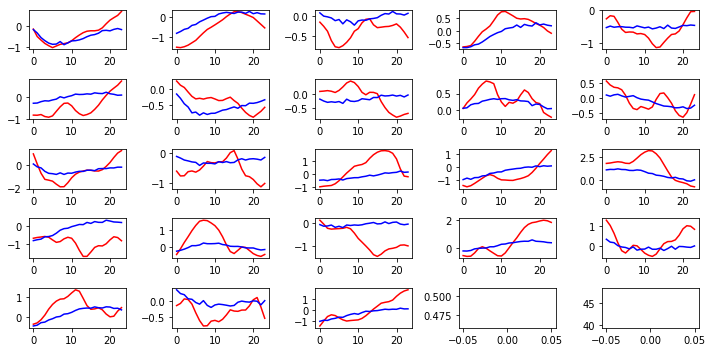

Step: 0, Train Loss: 0.5095846056938171
Step: 50, Train Loss: 0.4282572865486145
Step: 100, Train Loss: 0.3903335928916931
Step: 150, Train Loss: 0.38159069418907166
Step: 200, Train Loss: 0.36071693897247314
Step: 250, Train Loss: 0.35082992911338806
Step: 300, Train Loss: 0.3825685977935791
Step: 350, Train Loss: 0.3500395715236664
Step: 400, Train Loss: 0.37155377864837646
Step: 450, Train Loss: 0.40880560874938965
Step: 500, Train Loss: 0.3973819613456726
Step: 550, Train Loss: 0.37296125292778015
Step: 600, Train Loss: 0.28915369510650635
Step: 650, Train Loss: 0.3508448004722595
Step: 700, Train Loss: 0.2902870774269104
Step: 750, Train Loss: 0.360982745885849
Step: 800, Train Loss: 0.29541704058647156
Epoch: 2, Train loss: 0.3593736475430676
acskill_socre:75.37711482720808, rmse_score:13.55135853511938
acskill_socre:83.09474625143352, rmse_score:11.75609188878753
Epoch: 2, Valid Score: 61.8257562920887, Valid Score 2: 71.338654362646

Model saved successfully


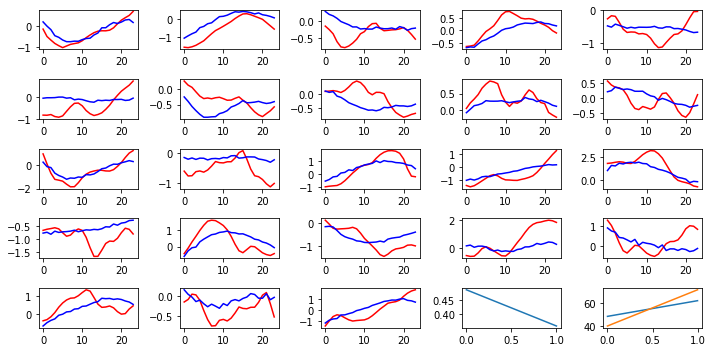

Step: 0, Train Loss: 0.2885337769985199
Step: 50, Train Loss: 0.30035170912742615
Step: 100, Train Loss: 0.276167094707489
Step: 150, Train Loss: 0.27340278029441833
Step: 200, Train Loss: 0.22518092393875122
Step: 250, Train Loss: 0.3158969283103943
Step: 300, Train Loss: 0.2125972956418991
Step: 350, Train Loss: 0.27111929655075073
Step: 400, Train Loss: 0.24144665896892548
Step: 450, Train Loss: 0.2779437005519867
Step: 500, Train Loss: 0.27012309432029724
Step: 550, Train Loss: 0.24729669094085693
Step: 600, Train Loss: 0.21702145040035248
Step: 650, Train Loss: 0.2824785113334656
Step: 700, Train Loss: 0.20531825721263885
Step: 750, Train Loss: 0.2437230944633484
Step: 800, Train Loss: 0.2353002279996872
Epoch: 3, Train loss: 0.2635864114379996
acskill_socre:85.26737511584145, rmse_score:12.755085942972041
acskill_socre:92.19835181683852, rmse_score:11.480693126244216
Epoch: 3, Valid Score: 72.5122891728694, Valid Score 2: 80.7176586905943

Model saved successfully


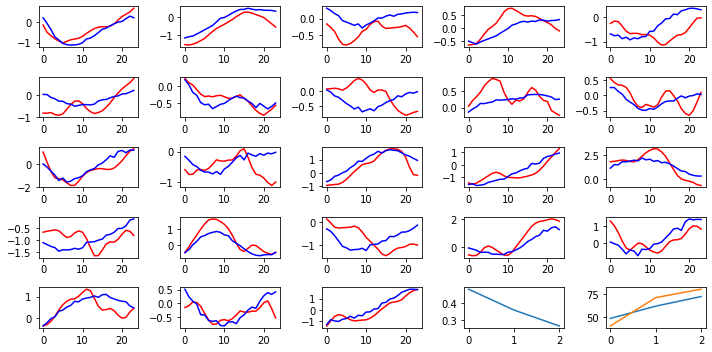

Step: 0, Train Loss: 0.20102587342262268
Step: 50, Train Loss: 0.22174569964408875
Step: 100, Train Loss: 0.22358137369155884
Step: 150, Train Loss: 0.17700514197349548
Step: 200, Train Loss: 0.19868549704551697
Step: 250, Train Loss: 0.18097534775733948
Step: 300, Train Loss: 0.22183816134929657
Step: 350, Train Loss: 0.152665376663208
Step: 400, Train Loss: 0.18552136421203613
Step: 450, Train Loss: 0.1614203304052353
Step: 500, Train Loss: 0.21730545163154602
Step: 550, Train Loss: 0.18608331680297852
Step: 600, Train Loss: 0.16399481892585754
Step: 650, Train Loss: 0.15943318605422974
Step: 700, Train Loss: 0.14803920686244965
Step: 750, Train Loss: 0.19540852308273315
Step: 800, Train Loss: 0.15975621342658997
Epoch: 4, Train loss: 0.18678180322545399
acskill_socre:93.83170339021463, rmse_score:9.938080014933503
acskill_socre:97.21620258927771, rmse_score:8.621852160685728
Epoch: 4, Valid Score: 83.89362337528112, Valid Score 2: 88.59435042859198

Model saved successfully


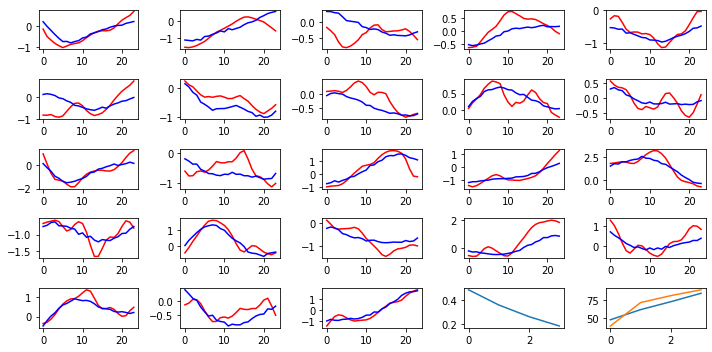

Step: 0, Train Loss: 0.1313038468360901
Step: 50, Train Loss: 0.15576307475566864
Step: 100, Train Loss: 0.11194615811109543
Step: 150, Train Loss: 0.14765898883342743
Step: 200, Train Loss: 0.14724314212799072
Step: 250, Train Loss: 0.13060609996318817
Step: 300, Train Loss: 0.13602189719676971
Step: 350, Train Loss: 0.1311185657978058
Step: 400, Train Loss: 0.14961081743240356
Step: 450, Train Loss: 0.14816683530807495
Step: 500, Train Loss: 0.12321817129850388
Step: 550, Train Loss: 0.1492772102355957
Step: 600, Train Loss: 0.15669772028923035
Step: 650, Train Loss: 0.15245871245861053
Step: 700, Train Loss: 0.13451126217842102
Step: 750, Train Loss: 0.14220398664474487
Step: 800, Train Loss: 0.150666743516922
Epoch: 5, Train loss: 0.13676552862917643
acskill_socre:98.09552195134741, rmse_score:8.774354826511091
acskill_socre:99.82961226292862, rmse_score:8.112939177778546
Epoch: 5, Valid Score: 89.32116712483632, Valid Score 2: 91.71667308515008

Model saved successfully


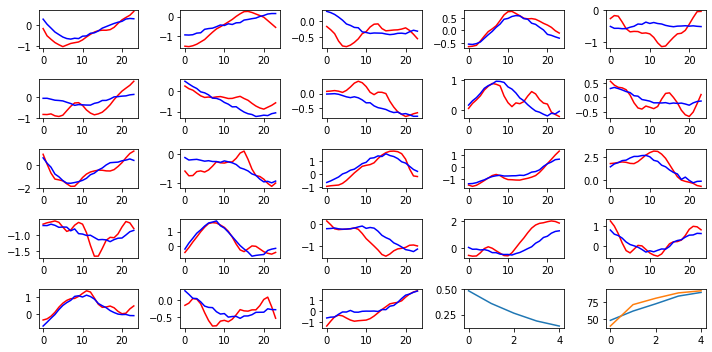

Step: 0, Train Loss: 0.12783145904541016
Step: 50, Train Loss: 0.12664084136486053
Step: 100, Train Loss: 0.10814511030912399
Step: 150, Train Loss: 0.09438460320234299
Step: 200, Train Loss: 0.10944914817810059
Step: 250, Train Loss: 0.09440547227859497
Step: 300, Train Loss: 0.12002997100353241
Step: 350, Train Loss: 0.09825291484594345
Step: 400, Train Loss: 0.15875616669654846
Step: 450, Train Loss: 0.1521415114402771
Step: 500, Train Loss: 0.10496094077825546
Step: 550, Train Loss: 0.11512767523527145
Step: 600, Train Loss: 0.13051673769950867
Step: 650, Train Loss: 0.0940893143415451
Step: 700, Train Loss: 0.10053269565105438
Step: 750, Train Loss: 0.08709286153316498
Step: 800, Train Loss: 0.11931966245174408
Epoch: 6, Train loss: 0.10606908719651224
acskill_socre:99.95863512012772, rmse_score:7.905655436451921
acskill_socre:101.28477722059017, rmse_score:7.272244425046219
Epoch: 6, Valid Score: 92.0529796836758, Valid Score 2: 94.01253279554395

Model saved successfully


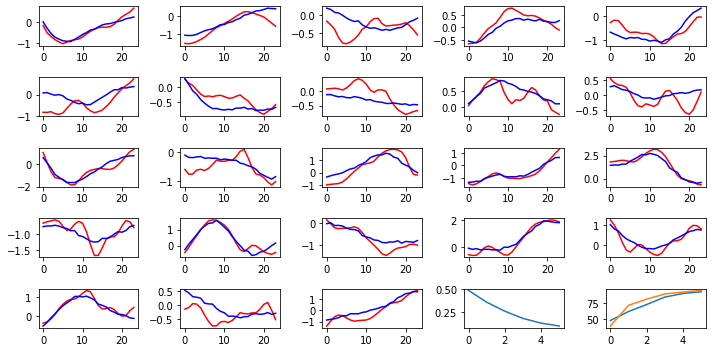

Step: 0, Train Loss: 0.10135732591152191
Step: 50, Train Loss: 0.08826428651809692
Step: 100, Train Loss: 0.08554185926914215
Step: 150, Train Loss: 0.0715363547205925
Step: 200, Train Loss: 0.07674571126699448
Step: 250, Train Loss: 0.09854575246572495
Step: 300, Train Loss: 0.08354634046554565
Step: 350, Train Loss: 0.09220921993255615
Step: 400, Train Loss: 0.0872073620557785
Step: 450, Train Loss: 0.07646037638187408
Step: 500, Train Loss: 0.07619335502386093
Step: 550, Train Loss: 0.0824781134724617
Step: 600, Train Loss: 0.0952749103307724
Step: 650, Train Loss: 0.0956658124923706
Step: 700, Train Loss: 0.08092093467712402
Step: 750, Train Loss: 0.09562249481678009
Step: 800, Train Loss: 0.07851241528987885
Epoch: 7, Train loss: 0.08891096359816207
acskill_socre:101.17183543375972, rmse_score:7.947137225526604
acskill_socre:102.33532504875588, rmse_score:7.037794471203503
Epoch: 7, Valid Score: 93.22469820823312, Valid Score 2: 95.29753057755238

Model saved successfully


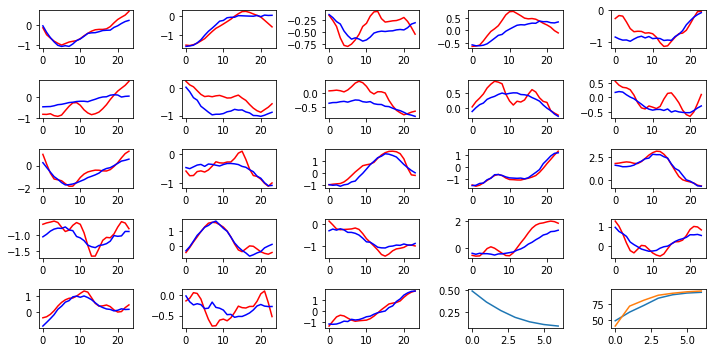

Step: 0, Train Loss: 0.06920987367630005
Step: 50, Train Loss: 0.07399605214595795
Step: 100, Train Loss: 0.08225350081920624
Step: 150, Train Loss: 0.0816759392619133
Step: 200, Train Loss: 0.068626269698143
Step: 250, Train Loss: 0.06497009098529816
Step: 300, Train Loss: 0.07223869860172272
Step: 350, Train Loss: 0.06411048769950867
Step: 400, Train Loss: 0.08002789318561554
Step: 450, Train Loss: 0.07648717612028122
Step: 500, Train Loss: 0.08796121925115585
Step: 550, Train Loss: 0.07619951665401459
Step: 600, Train Loss: 0.08566553890705109
Step: 650, Train Loss: 0.08785174787044525
Step: 700, Train Loss: 0.07722949981689453
Step: 750, Train Loss: 0.08429834246635437
Step: 800, Train Loss: 0.07747743278741837
Epoch: 8, Train loss: 0.07640645293280553
acskill_socre:102.55708869512239, rmse_score:7.133341108293442
acskill_socre:103.60990167348689, rmse_score:6.048929698628549
Epoch: 8, Valid Score: 95.42374758682895, Valid Score 2: 97.56097197485833

Model saved successfully


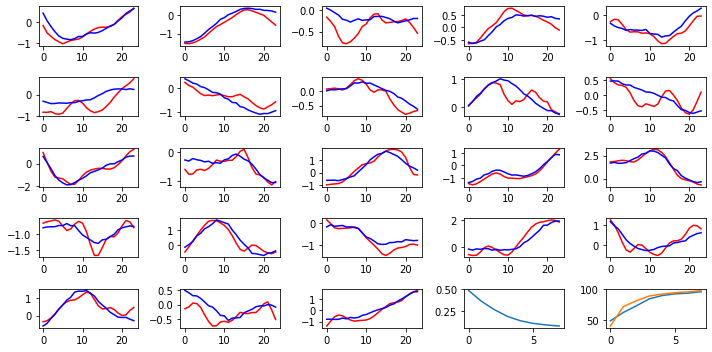

Step: 0, Train Loss: 0.07573597878217697
Step: 50, Train Loss: 0.06010627746582031
Step: 100, Train Loss: 0.06269576400518417
Step: 150, Train Loss: 0.07228054851293564
Step: 200, Train Loss: 0.06094755977392197
Step: 250, Train Loss: 0.07676375657320023
Step: 300, Train Loss: 0.0706413984298706
Step: 350, Train Loss: 0.05784694477915764
Step: 400, Train Loss: 0.07411929219961166
Step: 450, Train Loss: 0.0653531551361084
Step: 500, Train Loss: 0.05732160806655884
Step: 550, Train Loss: 0.05941597744822502
Step: 600, Train Loss: 0.067204549908638
Step: 650, Train Loss: 0.062139831483364105
Step: 700, Train Loss: 0.0645458921790123
Step: 750, Train Loss: 0.0701492577791214
Step: 800, Train Loss: 0.06022431701421738
Epoch: 9, Train loss: 0.06573416751266514
acskill_socre:103.34084756708626, rmse_score:6.566880597652714
acskill_socre:103.95464951061741, rmse_score:5.619496197248571
Epoch: 9, Valid Score: 96.77396696943354, Valid Score 2: 98.33515331336885

Model saved successfully


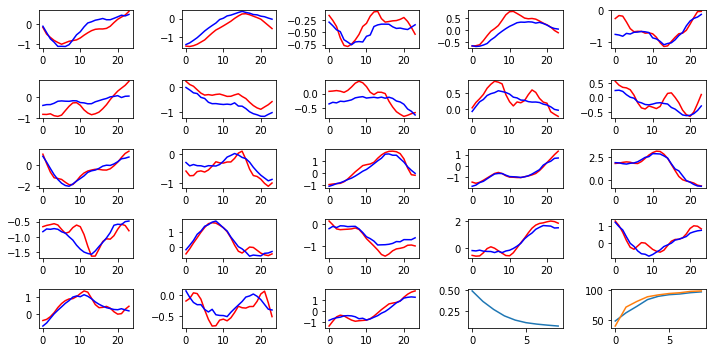

Step: 0, Train Loss: 0.06052539870142937
Step: 50, Train Loss: 0.07423322647809982
Step: 100, Train Loss: 0.05731773003935814
Step: 150, Train Loss: 0.053286656737327576
Step: 200, Train Loss: 0.061888813972473145
Step: 250, Train Loss: 0.06022720783948898
Step: 300, Train Loss: 0.06313922256231308
Step: 350, Train Loss: 0.05403295159339905
Step: 400, Train Loss: 0.06597065925598145
Step: 450, Train Loss: 0.06445946544408798
Step: 500, Train Loss: 0.06596384942531586
Step: 550, Train Loss: 0.05693575739860535
Step: 600, Train Loss: 0.05526841804385185
Step: 650, Train Loss: 0.08013974130153656
Step: 700, Train Loss: 0.05826767906546593
Step: 750, Train Loss: 0.07813405990600586
Step: 800, Train Loss: 0.056041400879621506
Epoch: 10, Train loss: 0.05969054359165837
acskill_socre:103.75484514761223, rmse_score:6.80657700554242
acskill_socre:104.33319878452477, rmse_score:5.765151958534129
Epoch: 10, Valid Score: 96.94826814206981, Valid Score 2: 98.56804682599063

Model saved successfully

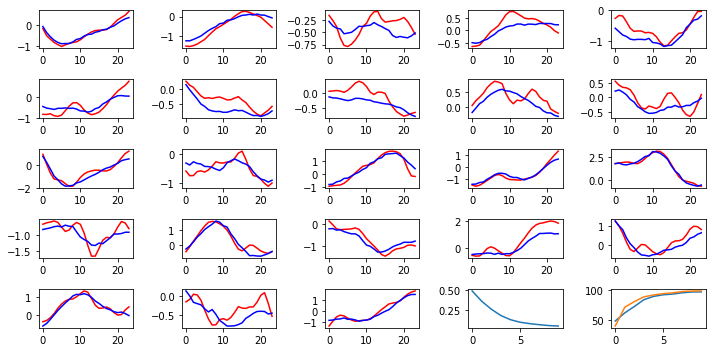

Step: 0, Train Loss: 0.049969062209129333
Step: 50, Train Loss: 0.05399095267057419
Step: 100, Train Loss: 0.06214284524321556
Step: 150, Train Loss: 0.051201771944761276
Step: 200, Train Loss: 0.05021598935127258
Step: 250, Train Loss: 0.05749577283859253
Step: 300, Train Loss: 0.050268422812223434
Step: 350, Train Loss: 0.0480826199054718
Step: 400, Train Loss: 0.06628169864416122
Step: 450, Train Loss: 0.05706238001585007
Step: 500, Train Loss: 0.05884110927581787
Step: 550, Train Loss: 0.061241697520017624
Step: 600, Train Loss: 0.05208897218108177
Step: 650, Train Loss: 0.04703288525342941
Step: 700, Train Loss: 0.0496513694524765
Step: 750, Train Loss: 0.060534488409757614
Step: 800, Train Loss: 0.058364368975162506
Epoch: 11, Train loss: 0.05322991438227666
acskill_socre:104.80528801164462, rmse_score:5.759129572407469
acskill_socre:105.37192209135239, rmse_score:4.946266853788625
Epoch: 11, Valid Score: 99.04615843923715, Valid Score 2: 100.42565523756376

Model saved successfu

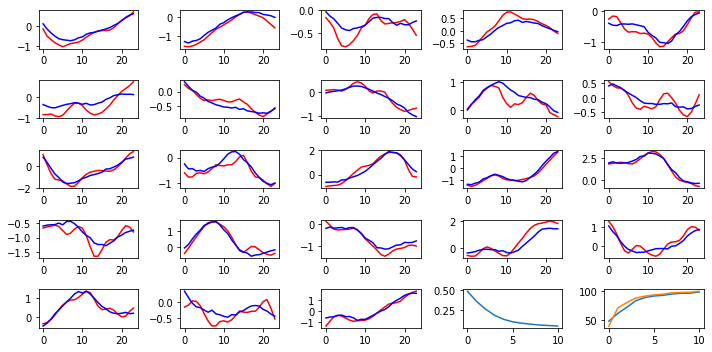

Step: 0, Train Loss: 0.04646427556872368
Step: 50, Train Loss: 0.03915691748261452
Step: 100, Train Loss: 0.043301939964294434
Step: 150, Train Loss: 0.04523462802171707
Step: 200, Train Loss: 0.06114014983177185
Step: 250, Train Loss: 0.04427076503634453
Step: 300, Train Loss: 0.04721052572131157
Step: 350, Train Loss: 0.05719124898314476
Step: 400, Train Loss: 0.058869149535894394
Step: 450, Train Loss: 0.04148029536008835
Step: 500, Train Loss: 0.05003941059112549
Step: 550, Train Loss: 0.0525214746594429
Step: 600, Train Loss: 0.04033710062503815
Step: 650, Train Loss: 0.04037245362997055
Step: 700, Train Loss: 0.047522928565740585
Step: 750, Train Loss: 0.05171099305152893
Step: 800, Train Loss: 0.04592163860797882
Epoch: 12, Train loss: 0.04806136642251676
acskill_socre:104.96844808413712, rmse_score:5.649917942910774
acskill_socre:105.33078674131372, rmse_score:4.965261140183714
Epoch: 12, Valid Score: 99.31853014122635, Valid Score 2: 100.36552560113

Model saved successfully


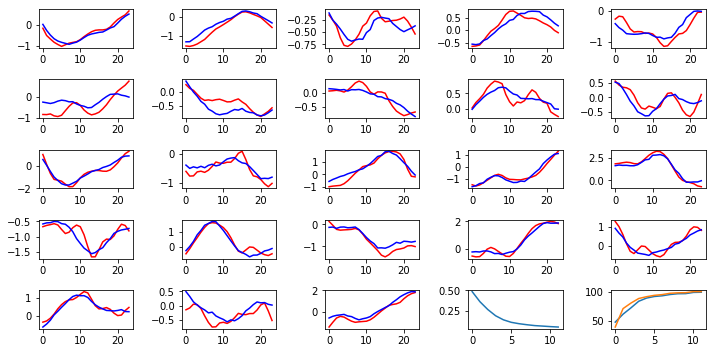

Step: 0, Train Loss: 0.03915011137723923
Step: 50, Train Loss: 0.04109317436814308
Step: 100, Train Loss: 0.048994164913892746
Step: 150, Train Loss: 0.042285989969968796
Step: 200, Train Loss: 0.04576537758111954
Step: 250, Train Loss: 0.04309247061610222
Step: 300, Train Loss: 0.04228067398071289
Step: 350, Train Loss: 0.05376563221216202
Step: 400, Train Loss: 0.048702873289585114
Step: 450, Train Loss: 0.040010690689086914
Step: 500, Train Loss: 0.04317954182624817
Step: 550, Train Loss: 0.04577779024839401
Step: 600, Train Loss: 0.04117703437805176
Step: 650, Train Loss: 0.03878404200077057
Step: 700, Train Loss: 0.034121252596378326
Step: 750, Train Loss: 0.03947635740041733
Step: 800, Train Loss: 0.04283657297492027
Epoch: 13, Train loss: 0.04351957446026011
acskill_socre:105.10899561625679, rmse_score:5.47628655466632
acskill_socre:105.66417421600649, rmse_score:4.8249980921318265
Epoch: 13, Valid Score: 99.63270906159048, Valid Score 2: 100.83917612387467

Model saved successf

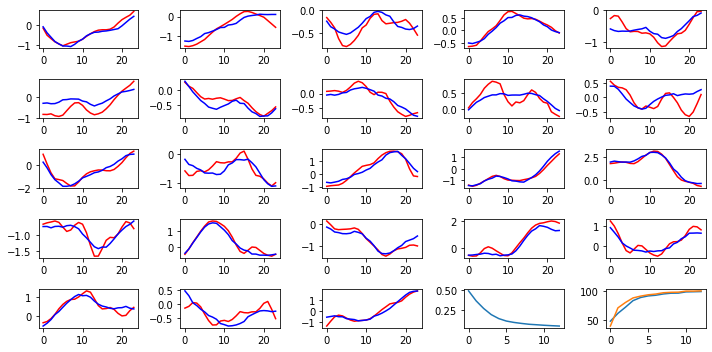

Step: 0, Train Loss: 0.039020050317049026
Step: 50, Train Loss: 0.041687801480293274
Step: 100, Train Loss: 0.03727957233786583
Step: 150, Train Loss: 0.03668444603681564
Step: 200, Train Loss: 0.03948767110705376
Step: 250, Train Loss: 0.03388523682951927
Step: 300, Train Loss: 0.04640592634677887
Step: 350, Train Loss: 0.040177151560783386
Step: 400, Train Loss: 0.03434690088033676
Step: 450, Train Loss: 0.04446207731962204
Step: 500, Train Loss: 0.043427105993032455
Step: 550, Train Loss: 0.034916460514068604
Step: 600, Train Loss: 0.038506846874952316
Step: 650, Train Loss: 0.04824529215693474
Step: 700, Train Loss: 0.03818907588720322
Step: 750, Train Loss: 0.0350399911403656
Step: 800, Train Loss: 0.045832715928554535
Epoch: 14, Train loss: 0.04090509806446272
acskill_socre:105.61934115058382, rmse_score:5.059478847460974
acskill_socre:105.70372568851447, rmse_score:4.625190730295133
Epoch: 14, Valid Score: 100.55986230312284, Valid Score 2: 101.07853495821934

Model saved succes

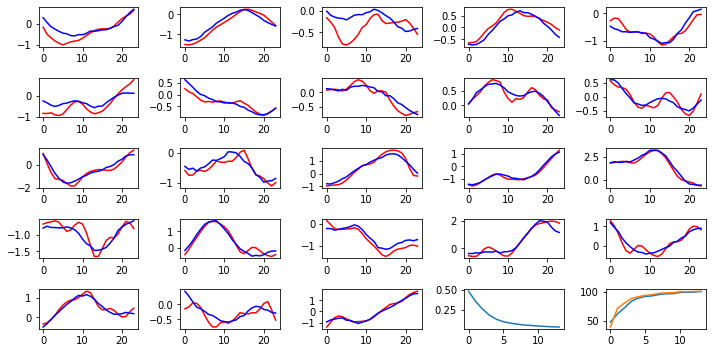

Step: 0, Train Loss: 0.03470918908715248
Step: 50, Train Loss: 0.041199829429388046
Step: 100, Train Loss: 0.03610311448574066
Step: 150, Train Loss: 0.04200249910354614
Step: 200, Train Loss: 0.030657371506094933
Step: 250, Train Loss: 0.036194369196891785
Step: 300, Train Loss: 0.036844778805971146
Step: 350, Train Loss: 0.05120184272527695
Step: 400, Train Loss: 0.03803025186061859
Step: 450, Train Loss: 0.03649638593196869
Step: 500, Train Loss: 0.03922185301780701
Step: 550, Train Loss: 0.03344450518488884
Step: 600, Train Loss: 0.03238276392221451
Step: 650, Train Loss: 0.03484516590833664
Step: 700, Train Loss: 0.034708939492702484
Step: 750, Train Loss: 0.03266816586256027
Step: 800, Train Loss: 0.03395362198352814
Epoch: 15, Train loss: 0.03750353727171912
acskill_socre:105.84730349345456, rmse_score:4.946124869716928
acskill_socre:105.99101896968077, rmse_score:4.532219372362947
Epoch: 15, Valid Score: 100.90117862373764, Valid Score 2: 101.45879959731782

Model saved success

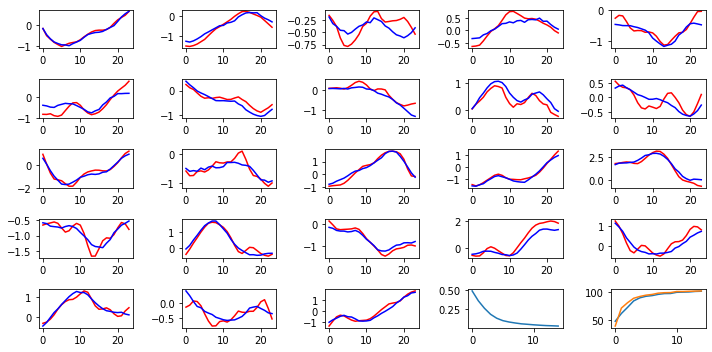

Step: 0, Train Loss: 0.0377146378159523
Step: 50, Train Loss: 0.03025420568883419
Step: 100, Train Loss: 0.03198885917663574
Step: 150, Train Loss: 0.03327656909823418
Step: 200, Train Loss: 0.031029030680656433
Step: 250, Train Loss: 0.03415457904338837
Step: 300, Train Loss: 0.03497138246893883
Step: 350, Train Loss: 0.03473455831408501
Step: 400, Train Loss: 0.03417355567216873
Step: 450, Train Loss: 0.03461460769176483
Step: 500, Train Loss: 0.03789348900318146
Step: 550, Train Loss: 0.03590436279773712
Step: 600, Train Loss: 0.03976559266448021
Step: 650, Train Loss: 0.04167643189430237
Step: 700, Train Loss: 0.04018855094909668
Step: 750, Train Loss: 0.038916803896427155
Step: 800, Train Loss: 0.03027017042040825
Epoch: 16, Train loss: 0.03514450355719828
acskill_socre:105.61606690162665, rmse_score:5.476289039497282
acskill_socre:106.08977166154855, rmse_score:4.705271154319949
Epoch: 16, Valid Score: 100.13977786212936, Valid Score 2: 101.38450050722861



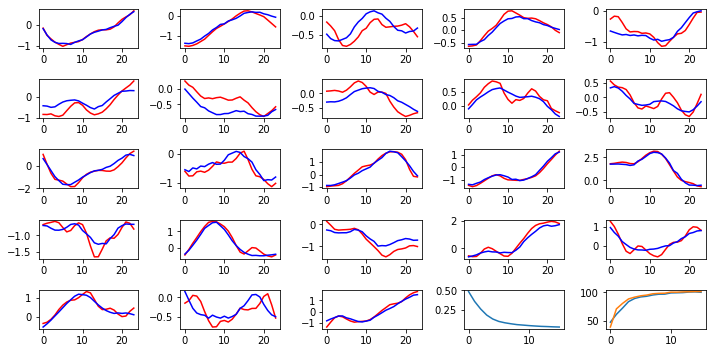

Step: 0, Train Loss: 0.030963754281401634
Step: 50, Train Loss: 0.032367631793022156
Step: 100, Train Loss: 0.03344988077878952
Step: 150, Train Loss: 0.02813909947872162
Step: 200, Train Loss: 0.04304943606257439
Step: 250, Train Loss: 0.030709970742464066
Step: 300, Train Loss: 0.029629183933138847
Step: 350, Train Loss: 0.03421921283006668
Step: 400, Train Loss: 0.03353830799460411
Step: 450, Train Loss: 0.03417661041021347
Step: 500, Train Loss: 0.036837946623563766
Step: 550, Train Loss: 0.03131375089287758
Step: 600, Train Loss: 0.03960138559341431
Step: 650, Train Loss: 0.031246041879057884
Step: 700, Train Loss: 0.03924893960356712
Step: 750, Train Loss: 0.03408939763903618
Step: 800, Train Loss: 0.03351446986198425
Epoch: 17, Train loss: 0.03274044057716267
acskill_socre:106.22085701766943, rmse_score:4.6585101581468695
acskill_socre:106.5046540028002, rmse_score:4.068114613858106
Epoch: 17, Valid Score: 101.56234685952256, Valid Score 2: 102.4365393889421

Model saved success

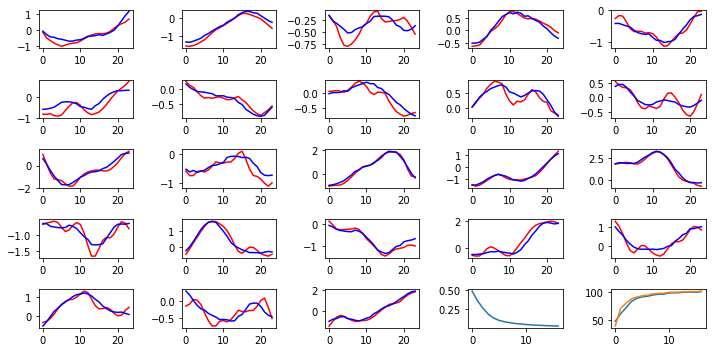

Step: 0, Train Loss: 0.028671301901340485
Step: 50, Train Loss: 0.03899064287543297
Step: 100, Train Loss: 0.03251773864030838
Step: 150, Train Loss: 0.034607261419296265
Step: 200, Train Loss: 0.03425421193242073
Step: 250, Train Loss: 0.032652150839567184
Step: 300, Train Loss: 0.026321452111005783
Step: 350, Train Loss: 0.027071869000792503
Step: 400, Train Loss: 0.03409946709871292
Step: 450, Train Loss: 0.026199936866760254
Step: 500, Train Loss: 0.029271822422742844
Step: 550, Train Loss: 0.0315161794424057
Step: 600, Train Loss: 0.026179006323218346
Step: 650, Train Loss: 0.03556966409087181
Step: 700, Train Loss: 0.02736804448068142
Step: 750, Train Loss: 0.02751212567090988
Step: 800, Train Loss: 0.0306398868560791
Epoch: 18, Train loss: 0.031138164986595863
acskill_socre:106.23182242142082, rmse_score:4.563350810965156
acskill_socre:106.36587232643262, rmse_score:4.1633970910582585
Epoch: 18, Valid Score: 101.66847161045565, Valid Score 2: 102.20247523537437

Model saved succ

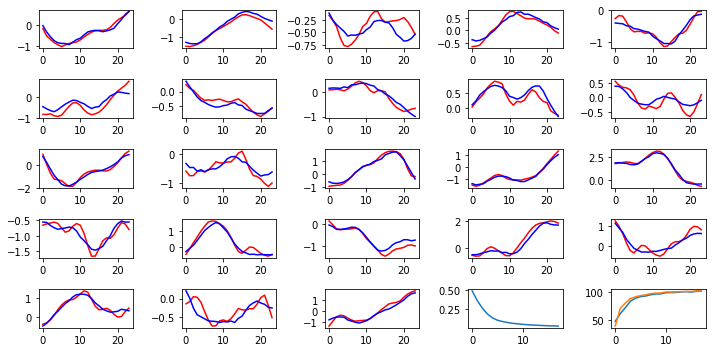

Step: 0, Train Loss: 0.029535597190260887
Step: 50, Train Loss: 0.030395563691854477
Step: 100, Train Loss: 0.027295950800180435
Step: 150, Train Loss: 0.026420578360557556
Step: 200, Train Loss: 0.02915038727223873
Step: 250, Train Loss: 0.032534800469875336
Step: 300, Train Loss: 0.028337672352790833
Step: 350, Train Loss: 0.026199212297797203
Step: 400, Train Loss: 0.029954906553030014
Step: 450, Train Loss: 0.02773566171526909
Step: 500, Train Loss: 0.03463999927043915
Step: 550, Train Loss: 0.03199997916817665
Step: 600, Train Loss: 0.025708787143230438
Step: 650, Train Loss: 0.02504107914865017
Step: 700, Train Loss: 0.02951885014772415
Step: 750, Train Loss: 0.027900390326976776
Step: 800, Train Loss: 0.026884159073233604
Epoch: 19, Train loss: 0.028935972329723468
acskill_socre:106.41679197501443, rmse_score:4.506236768985529
acskill_socre:106.8159072834506, rmse_score:3.8904630210443494
Epoch: 19, Valid Score: 101.9105552060289, Valid Score 2: 102.92544426240624

Model saved s

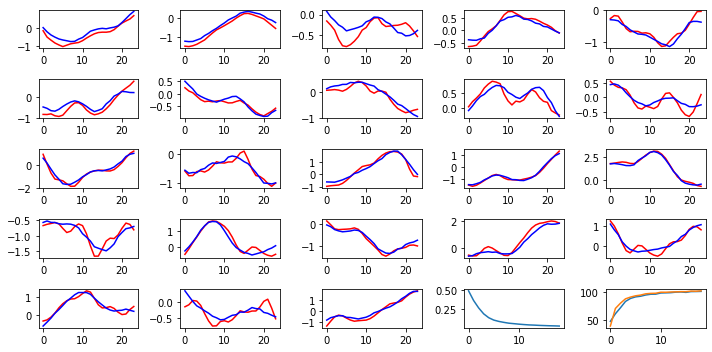

Step: 0, Train Loss: 0.028513364493846893
Step: 50, Train Loss: 0.024408534169197083
Step: 100, Train Loss: 0.030759772285819054
Step: 150, Train Loss: 0.026918431743979454
Step: 200, Train Loss: 0.025737395510077477
Step: 250, Train Loss: 0.02890320122241974
Step: 300, Train Loss: 0.03133956342935562
Step: 350, Train Loss: 0.0281155314296484
Step: 400, Train Loss: 0.02333487570285797
Step: 450, Train Loss: 0.028939202427864075
Step: 500, Train Loss: 0.025391321629285812
Step: 550, Train Loss: 0.02619221806526184
Step: 600, Train Loss: 0.026258409023284912
Step: 650, Train Loss: 0.03015272319316864
Step: 700, Train Loss: 0.023367471992969513
Step: 750, Train Loss: 0.024682220071554184
Step: 800, Train Loss: 0.028215404599905014
Epoch: 20, Train loss: 0.027652555558018353
acskill_socre:106.56252689345621, rmse_score:4.346778434382098
acskill_socre:106.92378513352631, rmse_score:3.80531961340968
Epoch: 20, Valid Score: 102.2157484590741, Valid Score 2: 103.11846552011663

Model saved suc

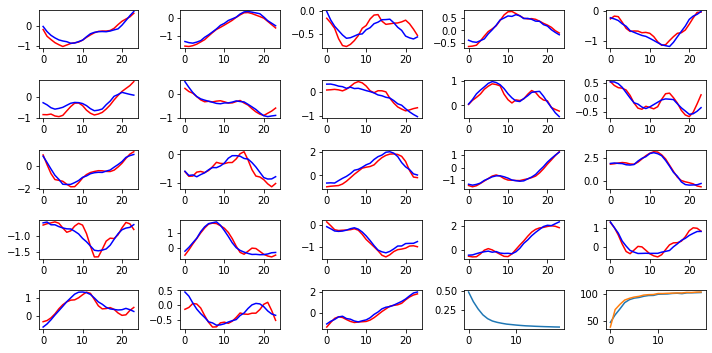

Step: 0, Train Loss: 0.02992444857954979
Step: 50, Train Loss: 0.02898072823882103
Step: 100, Train Loss: 0.026829449459910393
Step: 150, Train Loss: 0.024223996326327324
Step: 200, Train Loss: 0.02160492166876793
Step: 250, Train Loss: 0.024140533059835434
Step: 300, Train Loss: 0.026269137859344482
Step: 350, Train Loss: 0.026551466435194016
Step: 400, Train Loss: 0.028136029839515686
Step: 450, Train Loss: 0.02856077067553997
Step: 500, Train Loss: 0.029017284512519836
Step: 550, Train Loss: 0.023985937237739563
Step: 600, Train Loss: 0.02779669128358364
Step: 650, Train Loss: 0.02467966079711914
Step: 700, Train Loss: 0.02952434867620468
Step: 750, Train Loss: 0.025576092302799225
Step: 800, Train Loss: 0.025369297713041306
Epoch: 21, Train loss: 0.026515458847321042
acskill_socre:106.5125160291235, rmse_score:4.54734962396424
acskill_socre:107.0159448556175, rmse_score:3.8462836506042546
Epoch: 21, Valid Score: 101.96516640515927, Valid Score 2: 103.16966120501326



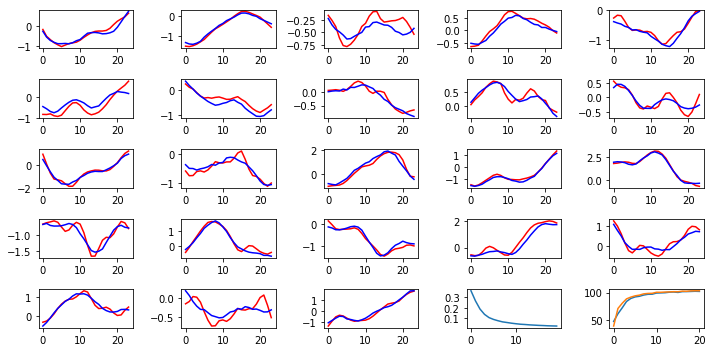

Step: 0, Train Loss: 0.02510935626924038
Step: 50, Train Loss: 0.024578627198934555
Step: 100, Train Loss: 0.023023921996355057
Step: 150, Train Loss: 0.02362804487347603
Step: 200, Train Loss: 0.02651938796043396
Step: 250, Train Loss: 0.02159925363957882


In [ ]:
train(num_epochs=50)

In [ ]:
# model.load_state_dict(torch.load('models/basemodel_best.pt'))

In [ ]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [ ]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
#     data_list = [SST,T300,Ua,Va]
#     SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

In [ ]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [ ]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [ ]:
make_zip()